In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load

In [2]:
hists = load('pods/hists_darkhiggs2018.coffea')
signal_hists = hists['signal']
bkg_hists    = hists['bkg']
data_hists   = hists['data']

In [64]:
exp = 0
region = 'isoneM'
jet_selection = 'mass4_isnotmonohs'
data={}
data['iszeroL'] = 'MET'
data['isoneM'] = 'MET'
data['isoneE'] = 'SingleElectron'
data['istwoM'] = 'MET'
data['istwoE'] = 'SingleElectron'
data['isoneA'] = 'SinglePhoton'
variable = 'recoil'
cut_bin = 0
cut_value_array = bkg_hists[variable].integrate('jet_selection','baggy').integrate('region','iszeroL').integrate('process', 'Mhs_50').axis(variable).edges(overflow='all')

print('------------------------')
print('------------------------')
print('Category:',jet_selection.split('_')[0])
#print('------------------------')
if cut_bin!=0: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].identifiers('process'):
    yld_array = bkg_hists[variable].integrate('jet_selection',jet_selection).integrate('region',region).integrate('process', p).values(overflow='all')
    if () in yld_array:
    #yld = np.sum(bkg_hists['recoil'].integrate('jet_selection',jet_selection).integrate('region',region).integrate('process', p).values(overflow='all')[()])
        yld = np.cumsum(yld_array[()])[16] - np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].identifiers('process'):
    yld_array = signal_hists[variable].integrate('jet_selection',jet_selection).integrate('region',region).integrate('process', p).values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[16] - np.cumsum(yld_array[()])[cut_bin]
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

yld_array = data_hists[variable].integrate('jet_selection',jet_selection).integrate('region',region).integrate('process', data[region]).values(overflow='all')
if () in yld_array and 'iszeroL' not in region:
    yld = np.cumsum(yld_array[()])[16] - np.cumsum(yld_array[()])[cut_bin]
    print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: mass4
------------------------
------------------------
Hbb 6.3
DY 1630.7
Diboson 1262.5
ST 1982.9
TT 10836.8
Wjets 72724.7
------------------------
Total expected: 88443.9
------------------------
Total observed: 89454.8
------------------------



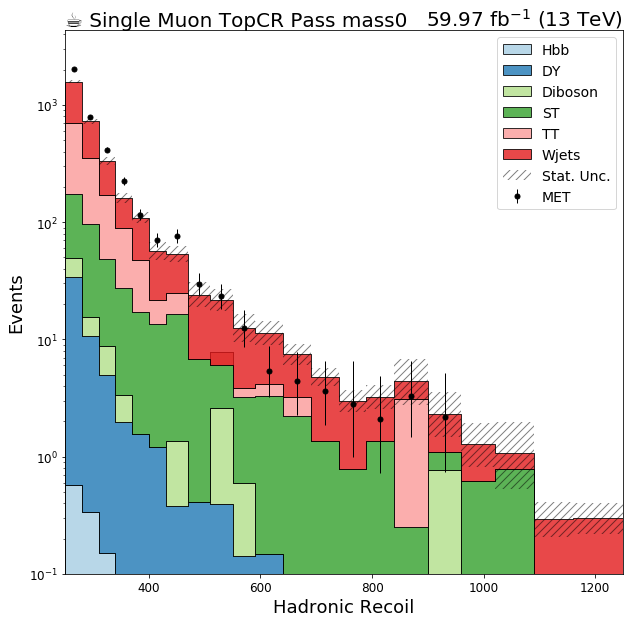

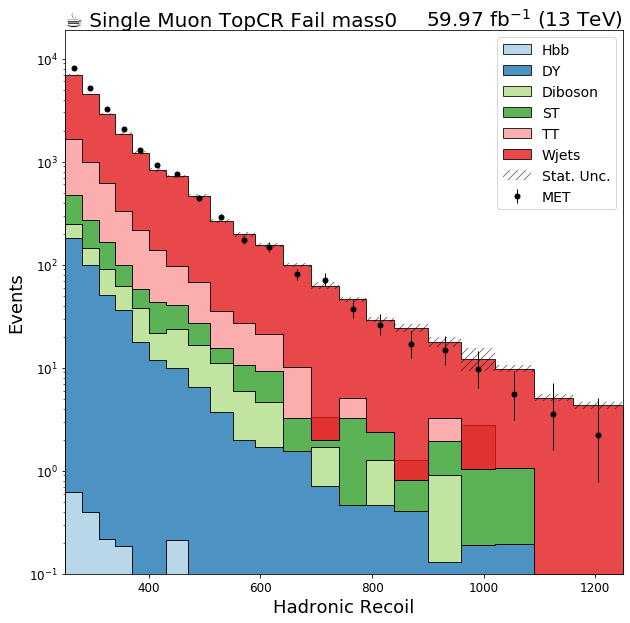

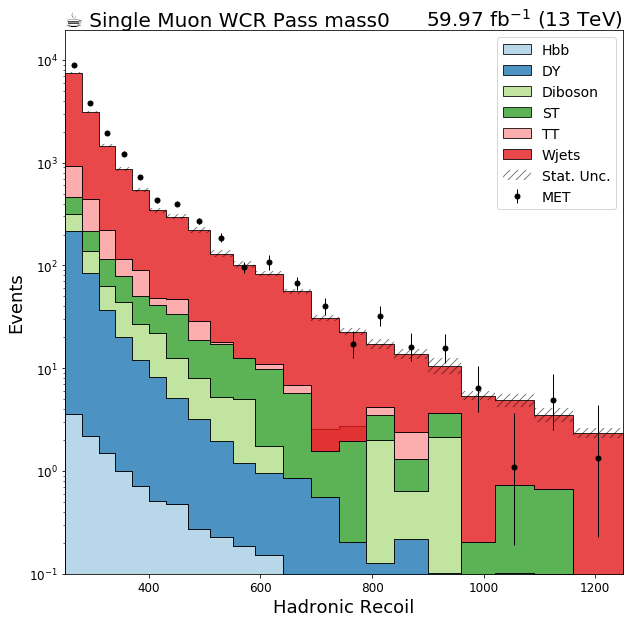

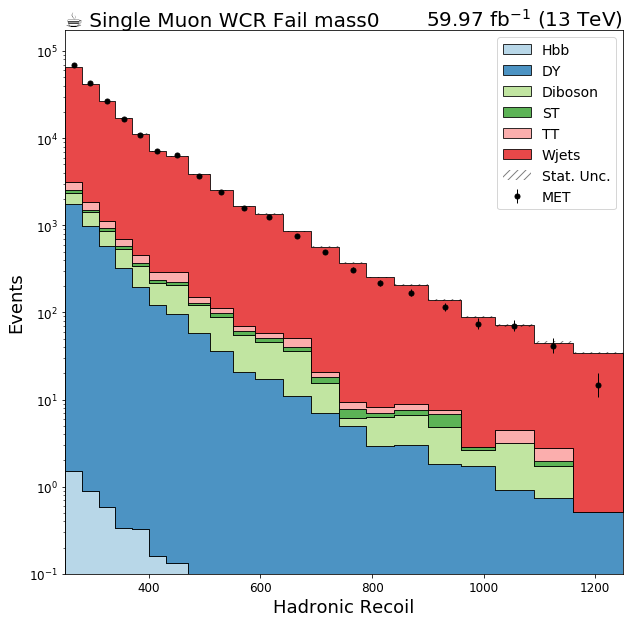

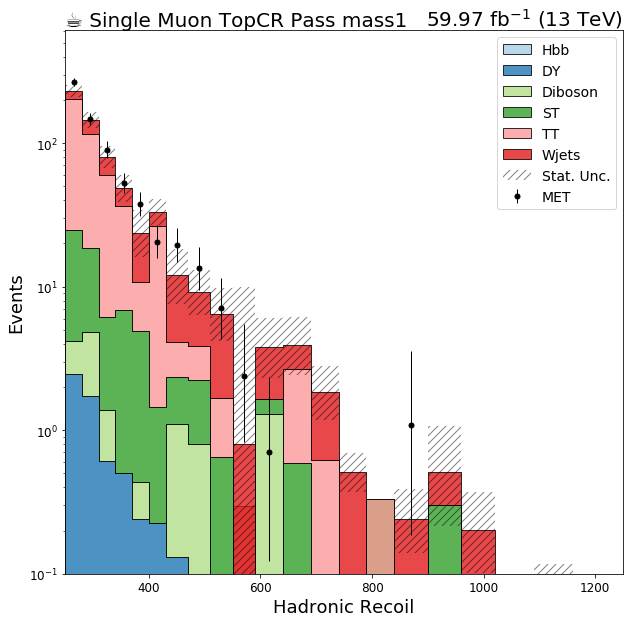

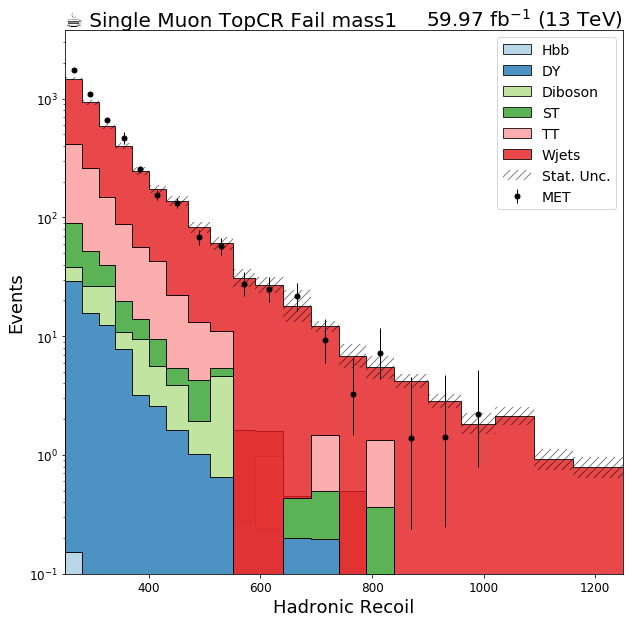

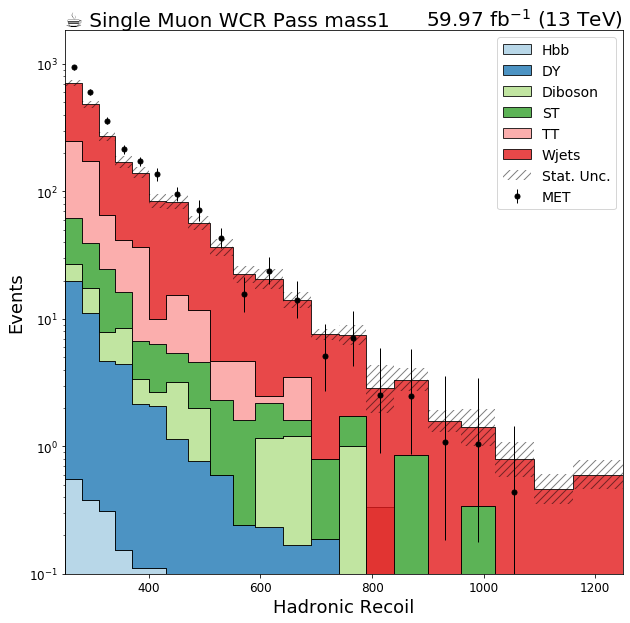

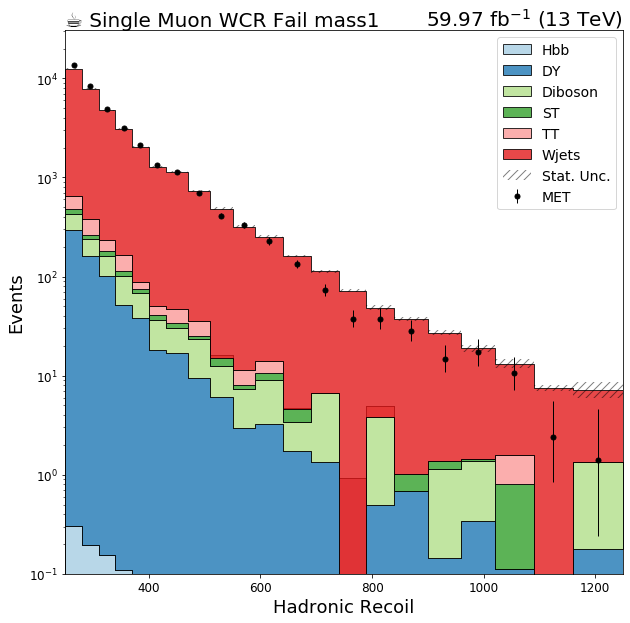

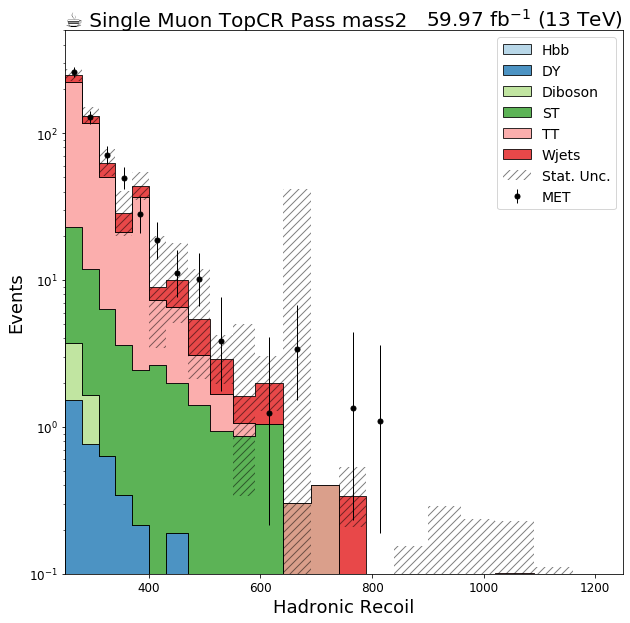

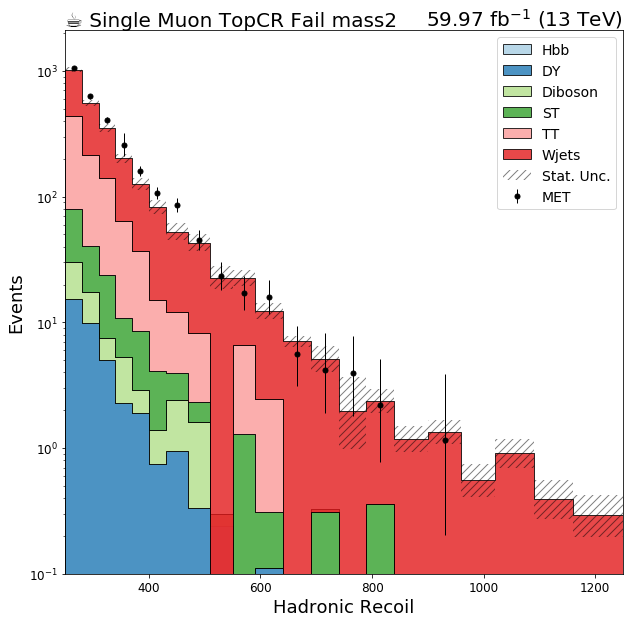

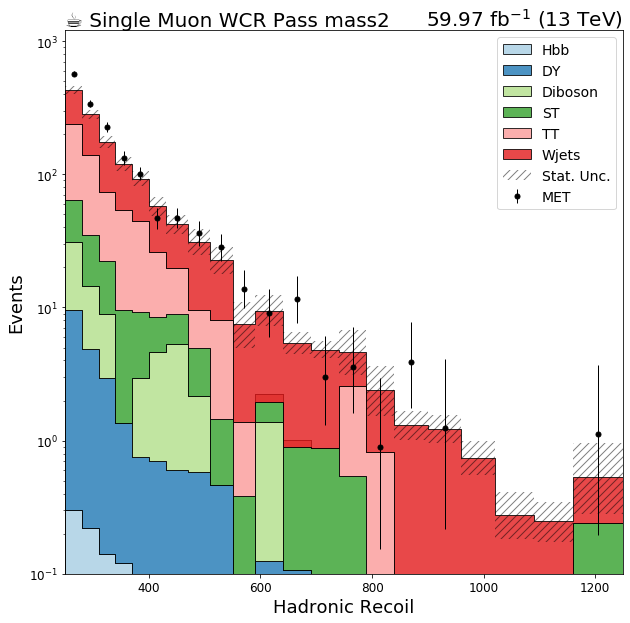

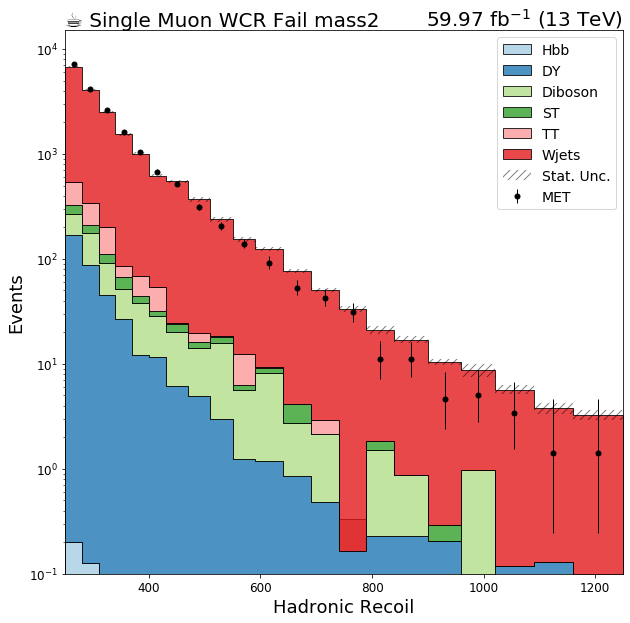

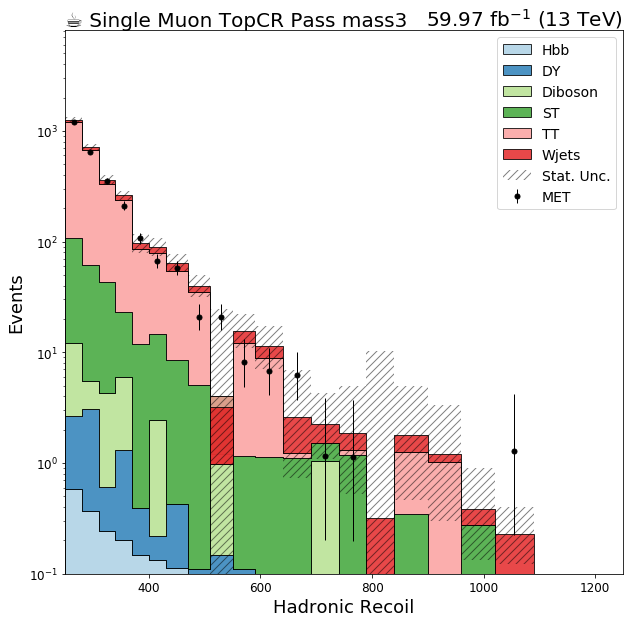

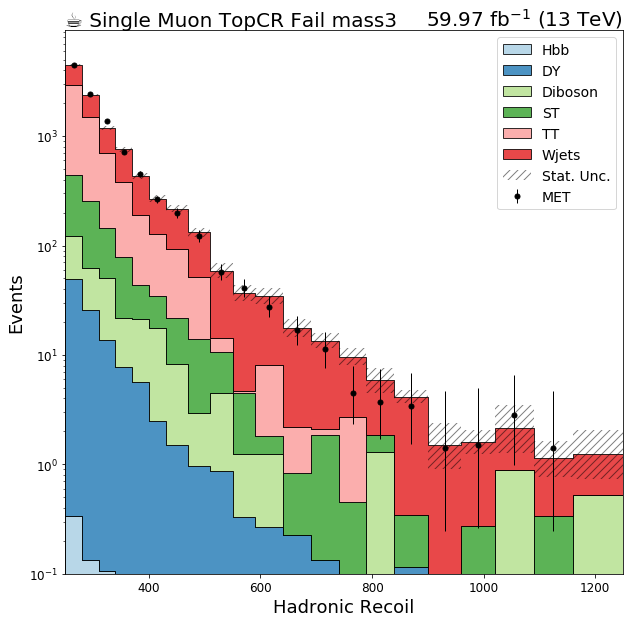

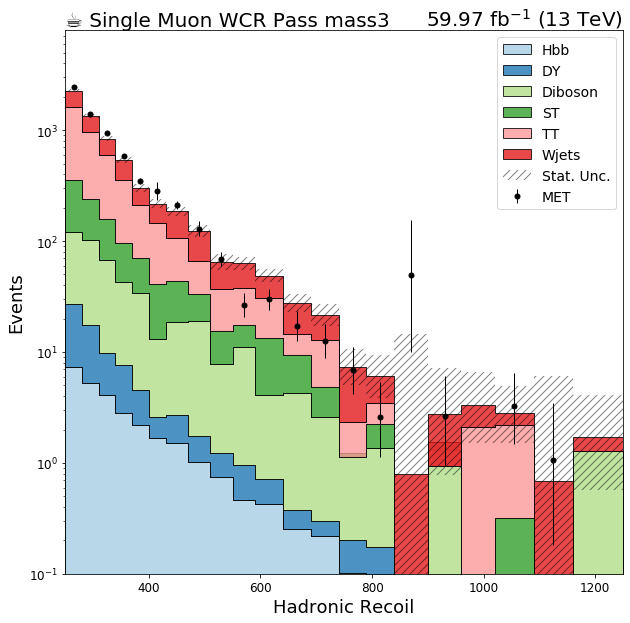

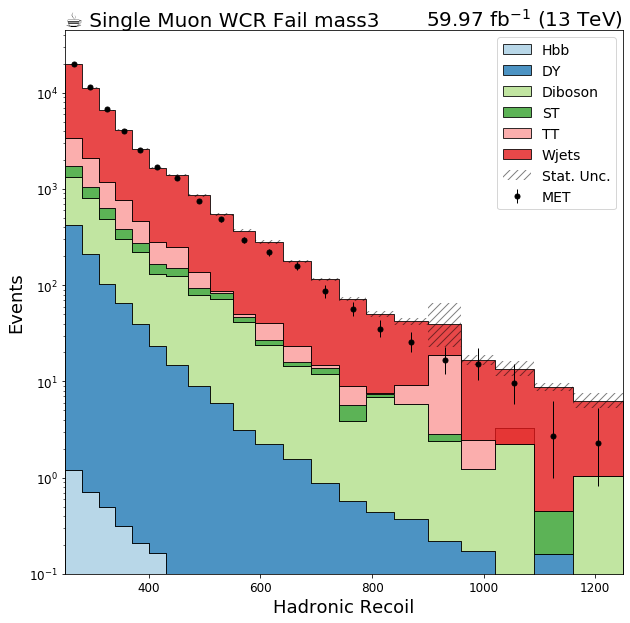

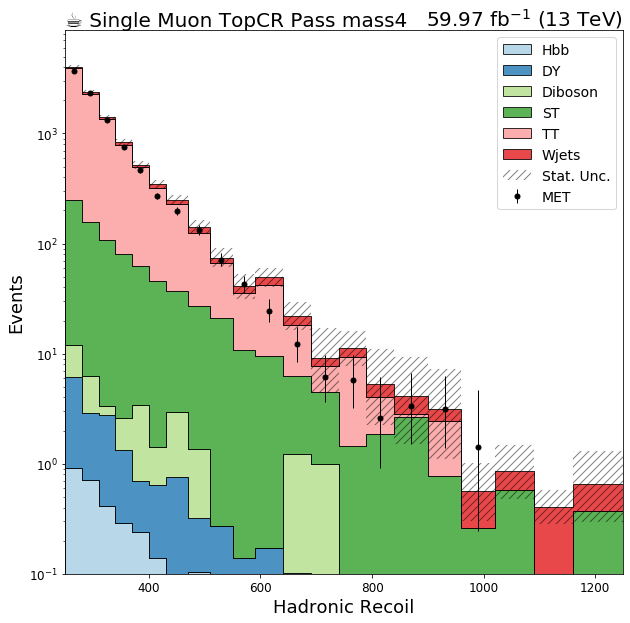

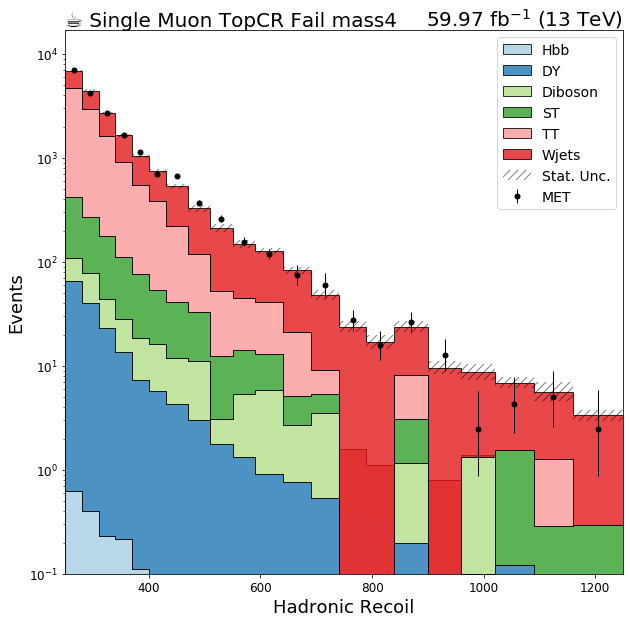

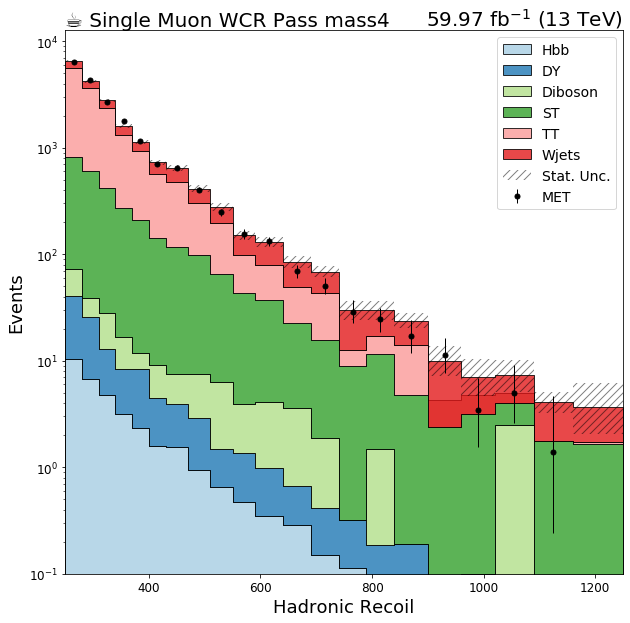

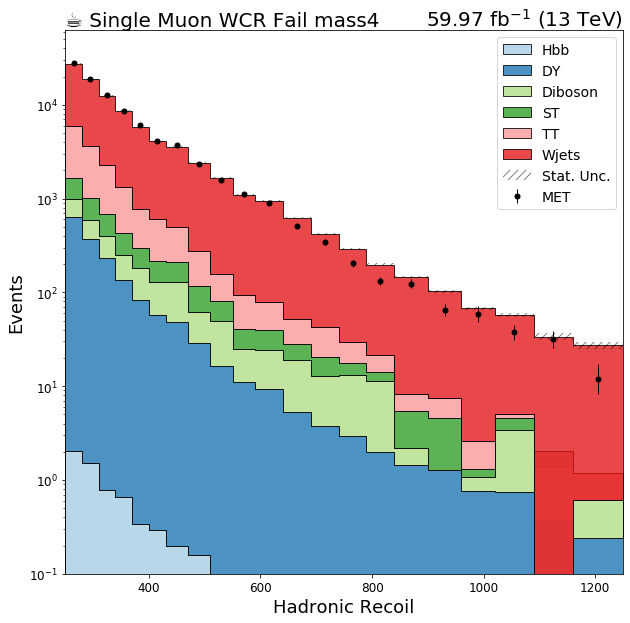

In [49]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('stack'):
    os.makedirs('stack')
    
region = 'isoneM'
R = {}
R['iszeroL'] = 'Signal Region'
R['isoneM'] = 'Single Muon WCR'
R['isoneMextrab'] = 'Single Muon TopCR'

for key in data_hists.keys():
    if key=='sumw': continue
    if key!='recoil' : continue
    
    for j in bkg_hists[key].identifiers('jet_selection'):
       
        deep = ''
        extrab = ''
        if 'baggy' in str(j): continue
        if 'inclusive' in str(j): continue
        if 'ismonohs' in str(j): deep='Pass'
        if 'isnotmonohs' in str(j): deep='Fail'
        if deep=='':continue
        if 'extrab' in str(j) and ('isoneM' in region or 'isoneE' in region): extrab = 'extrab'
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 0.8}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'none', 'marker': '.', 'markersize': 10., 'color':'k', 'elinewidth': 1, 'emarker': '_'}
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']


        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        ax.set_prop_cycle(cycler(color=colors))
        
        plot.plot1d(data_hists[key].integrate('jet_selection',j).integrate('region',region),            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )
        plot.plot1d(bkg_hists[key].integrate('jet_selection',j).integrate('region',region),
                overlay="process",
                ax=ax,
                clear=False,
                stack=True,
                #line_opts={'linestyle':'none', 'label':'_', 'alpha': 0.},
                #line_opts={'linestyle':'-','color':'k','label':'_'},
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        plot.plot1d(signal_hists[key].integrate('jet_selection',j).integrate('region',region), 
                    ax=ax, overlay="process", clear=False, stack=False, line_opts=args)
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        ax.set_ylim(.1, None)
        leg = ax.legend()
        
        coffee = plt.text(0., 1., u"☕ "+R[region+extrab]+" "+deep+" "+str(j).split('_')[0], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        lumi = plt.text(1., 1., r"59.97 fb$^{-1}$ (13 TeV)", fontsize=20, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        #plot_path = os.path.abspath('stack') 
        #plot_name = 'stack'+key+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))

ValueError: plot1d() can only support up to two dimensions (one for axis, one to stack or overlay)

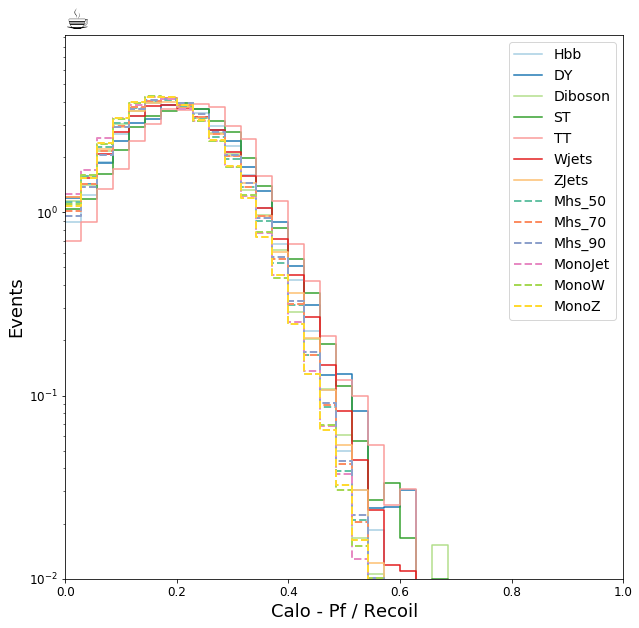

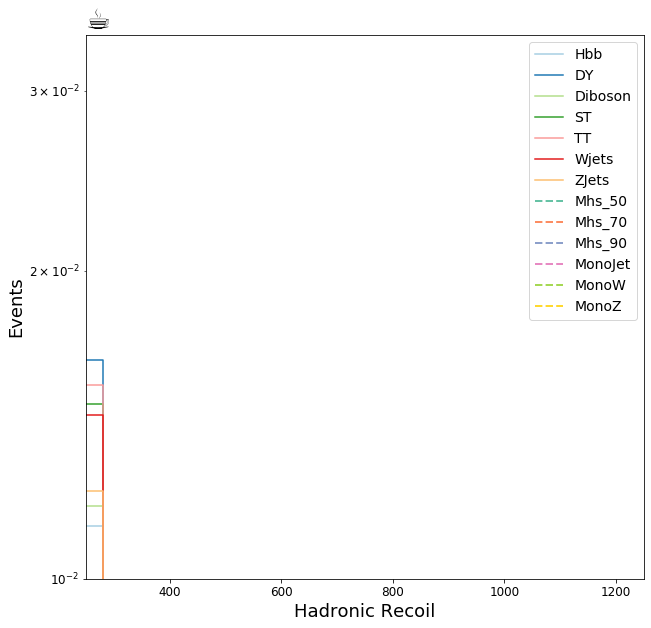

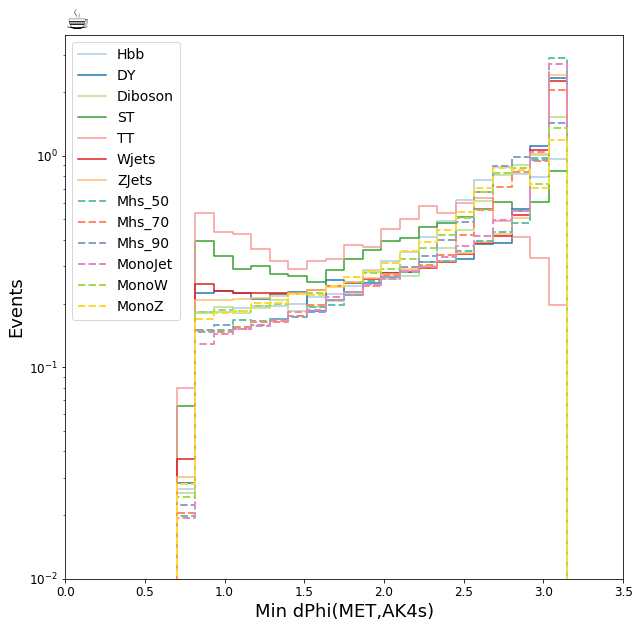

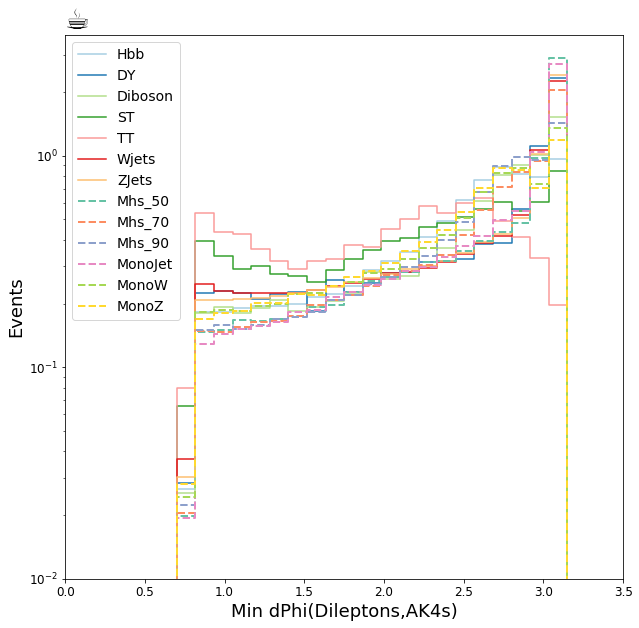

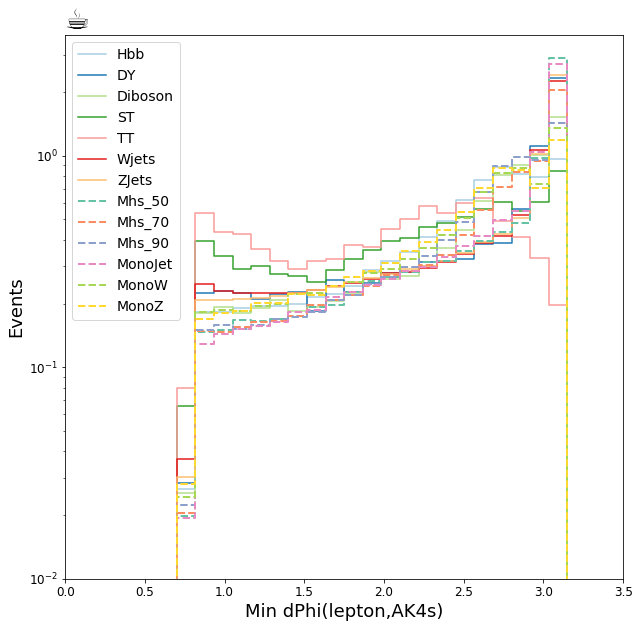

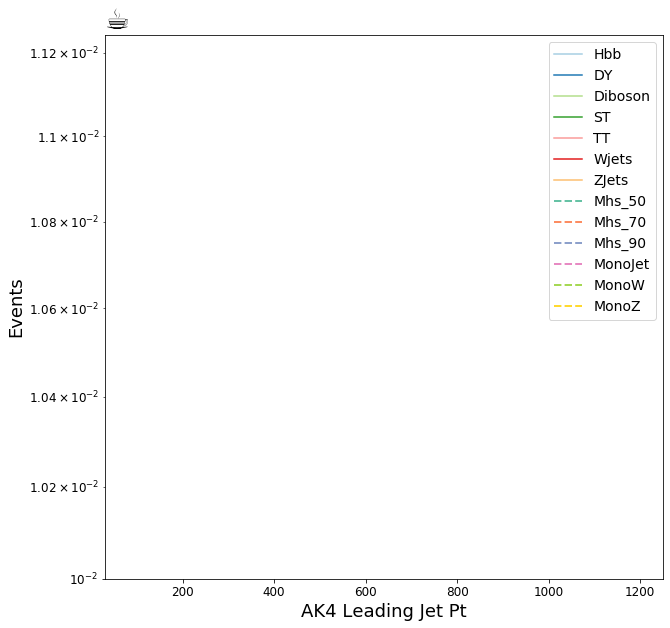

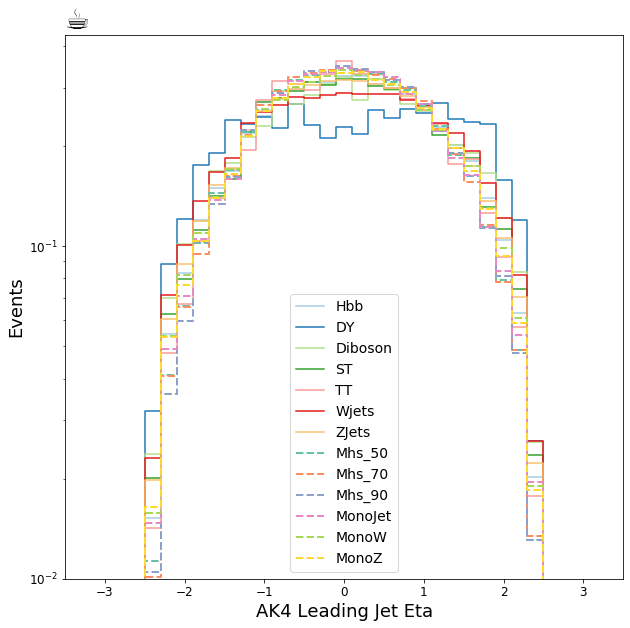

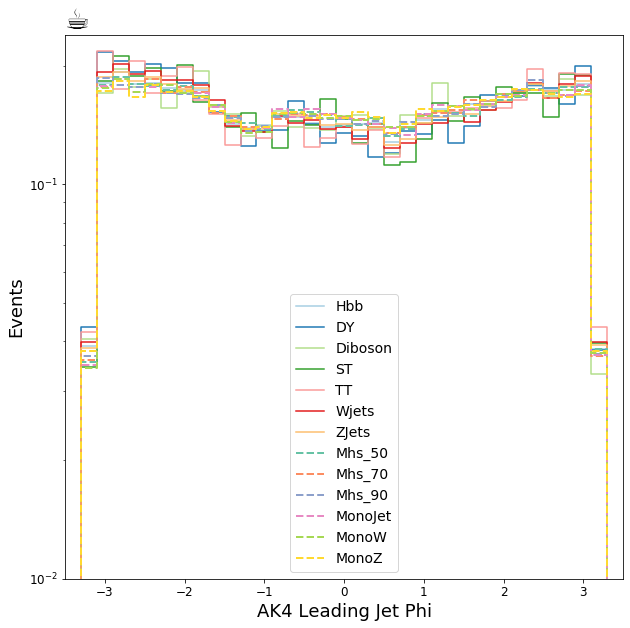

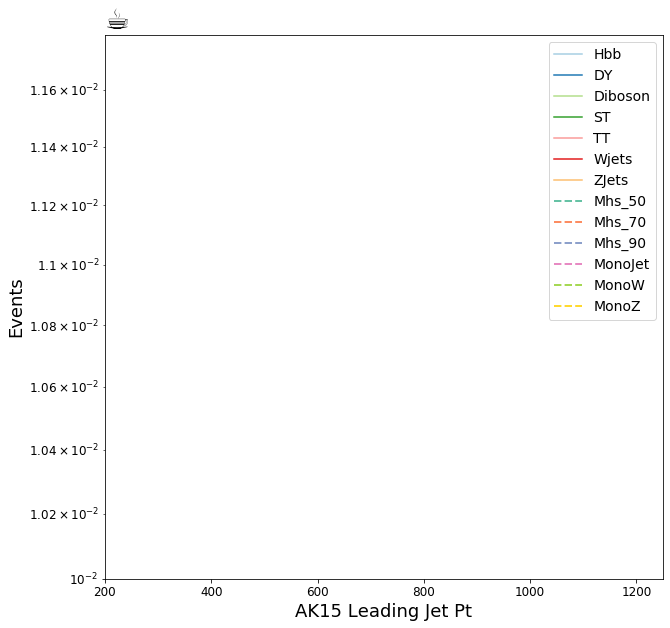

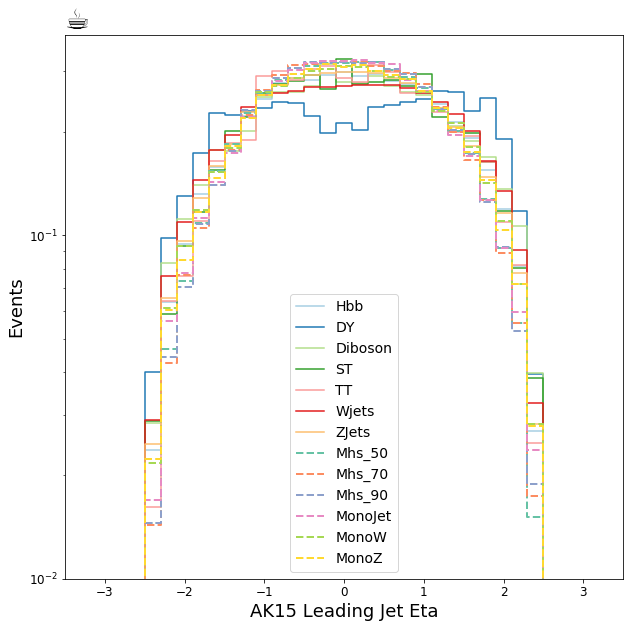

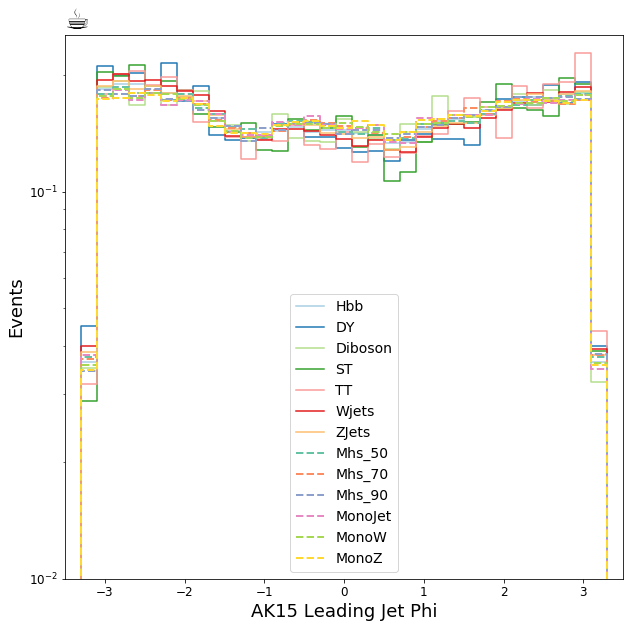

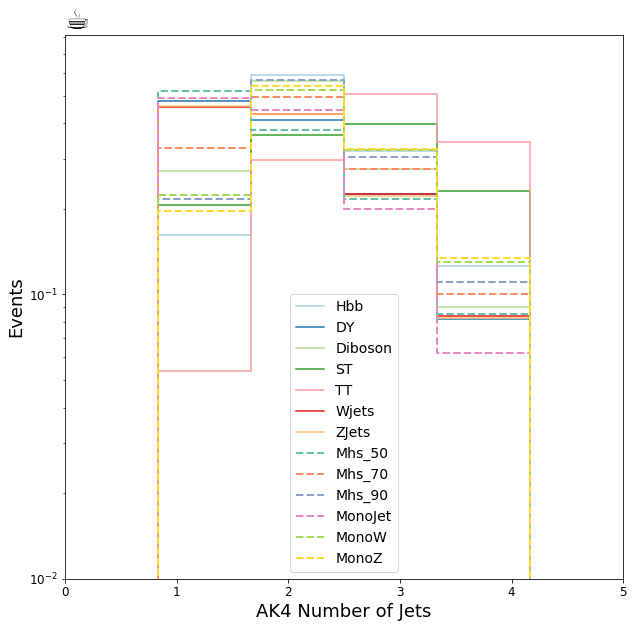

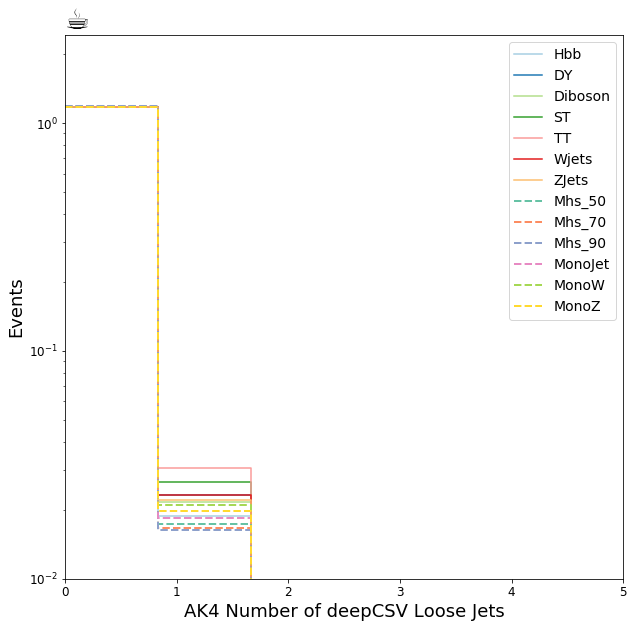

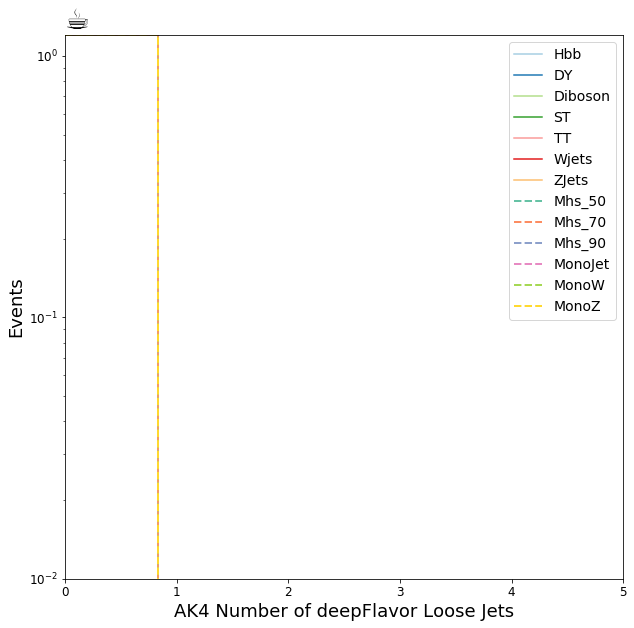

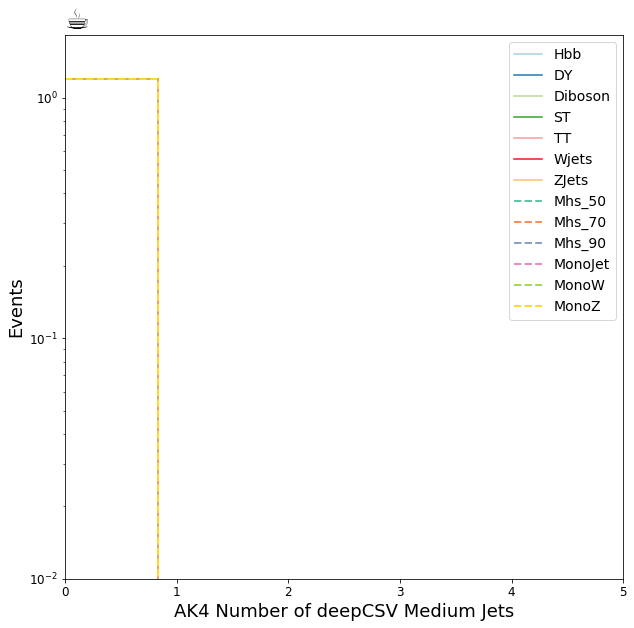

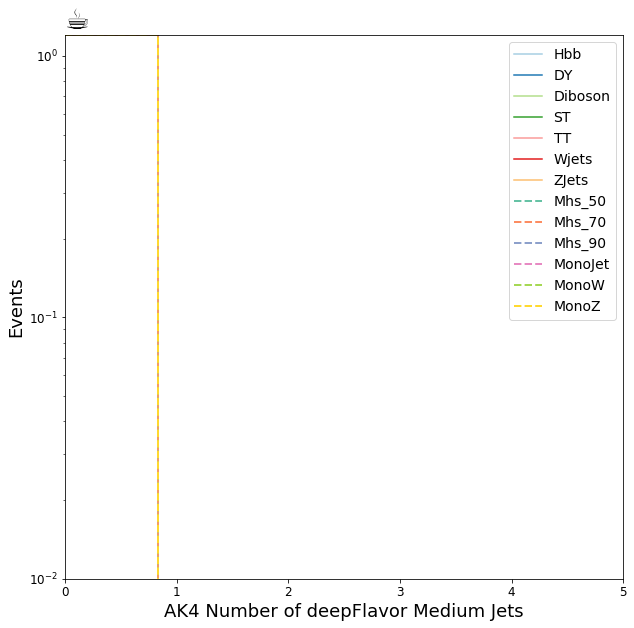

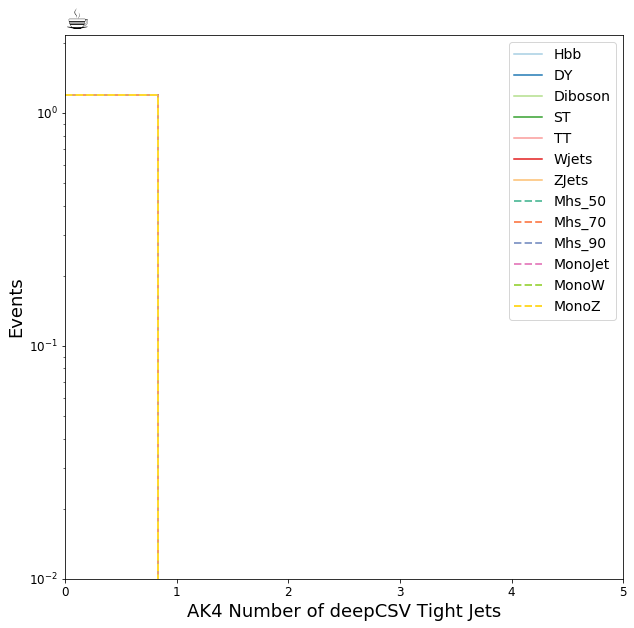

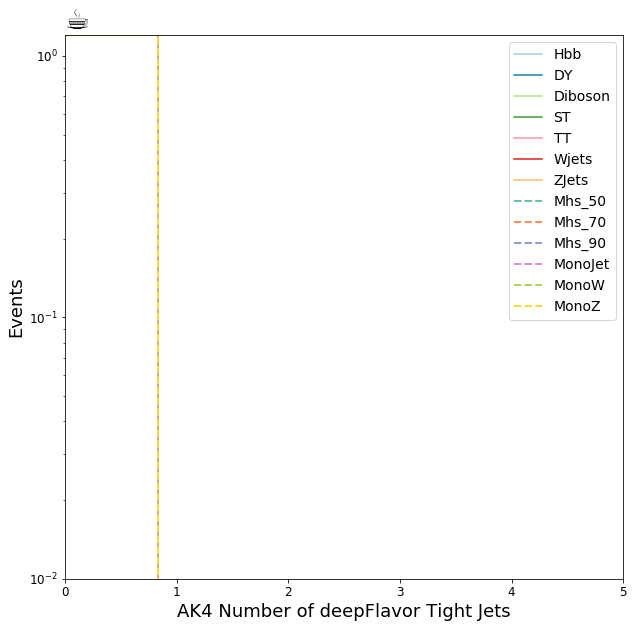

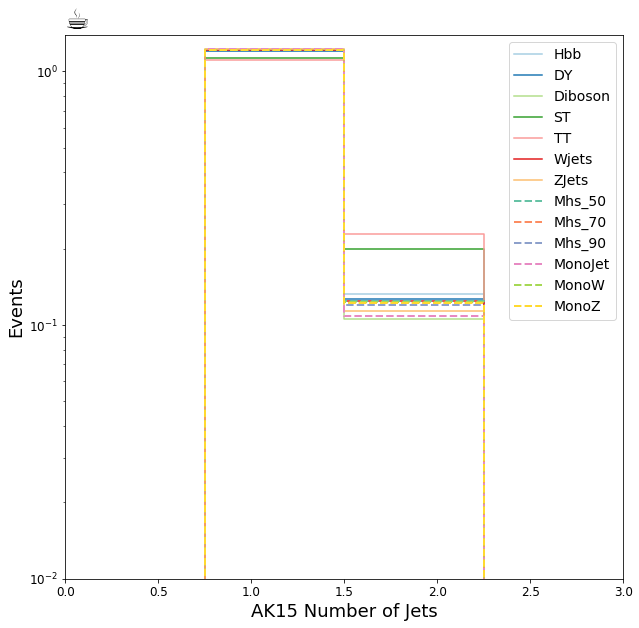

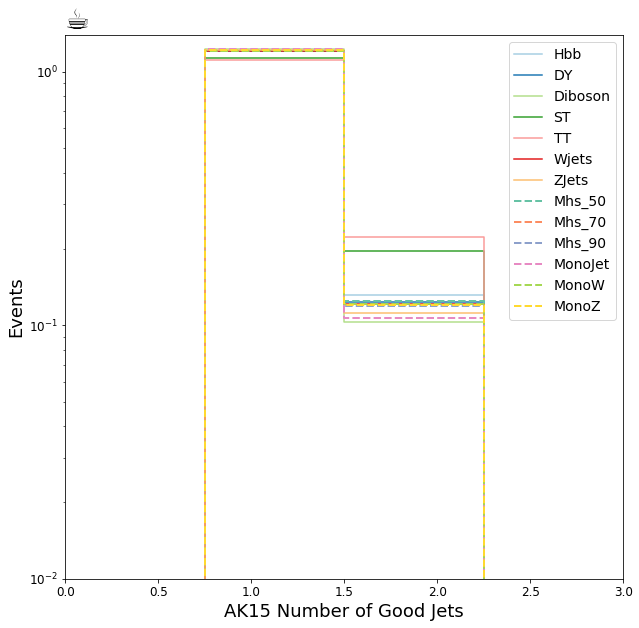

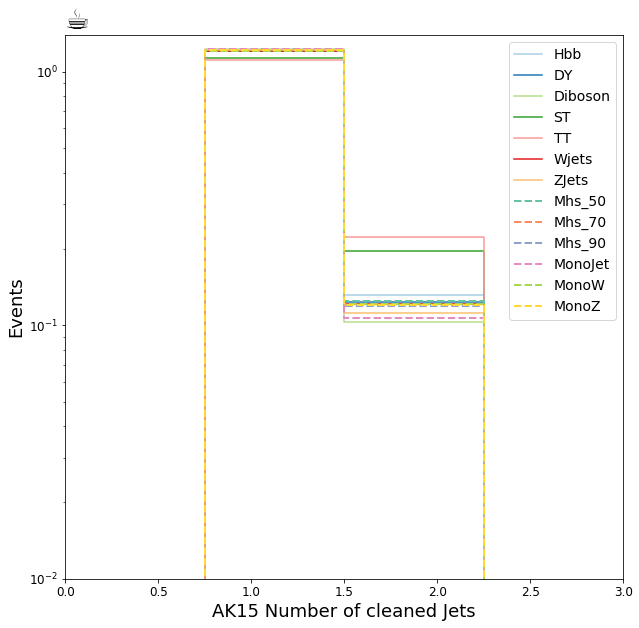

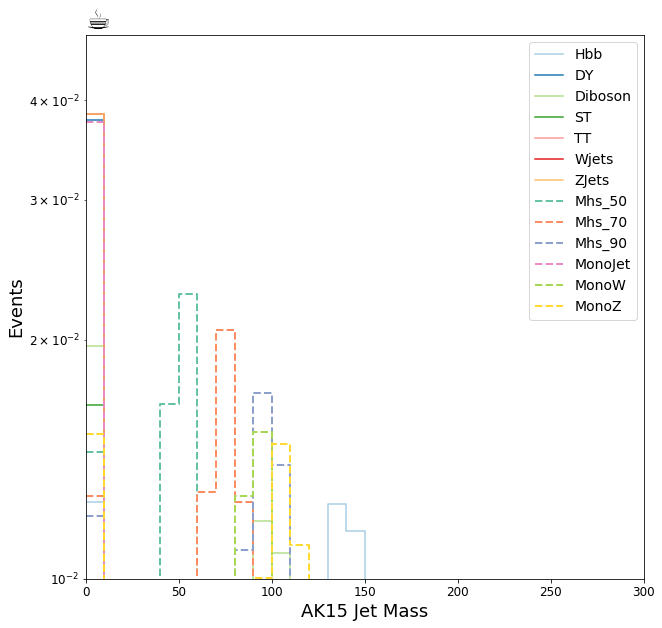

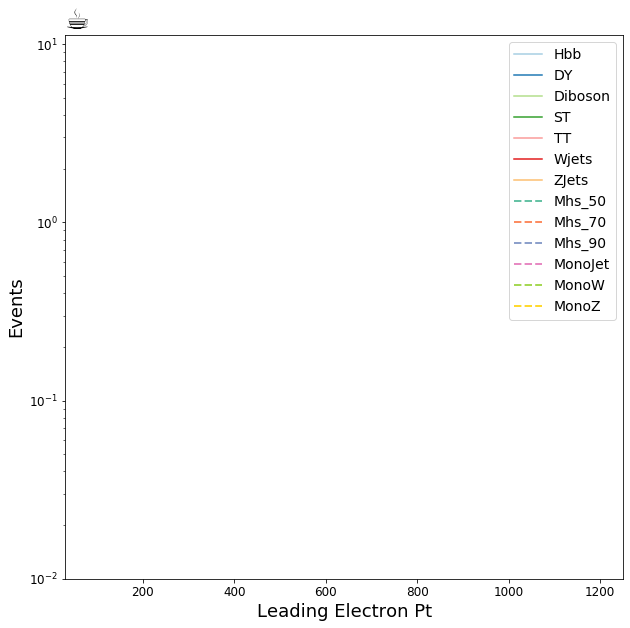

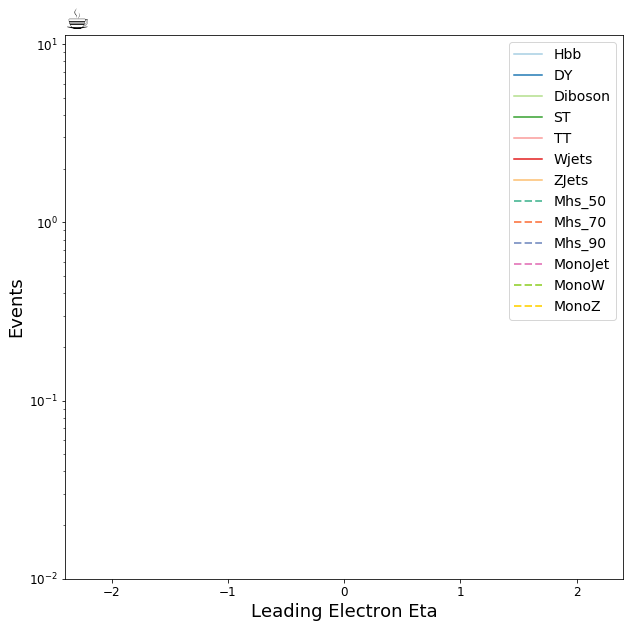

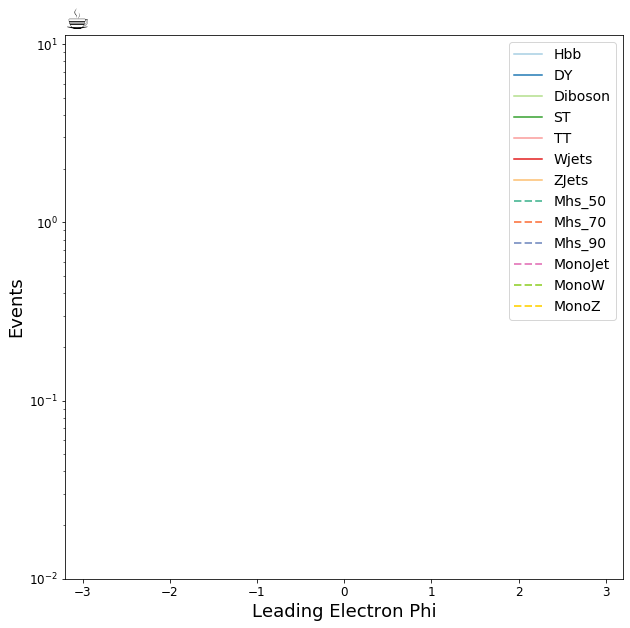

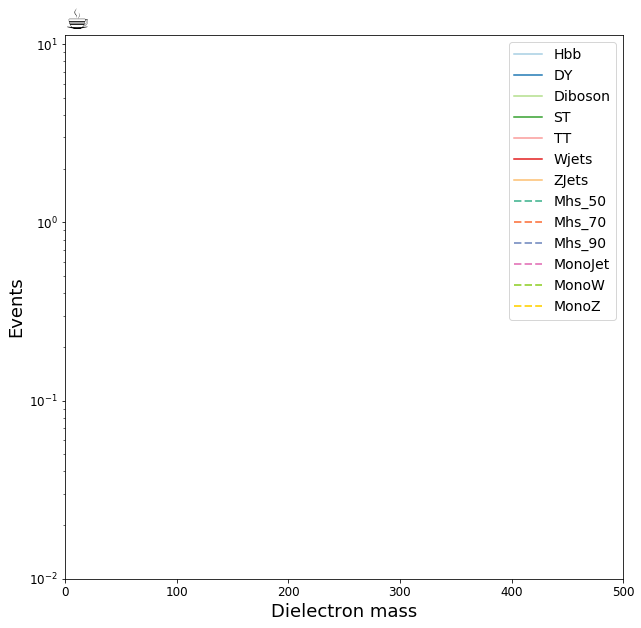

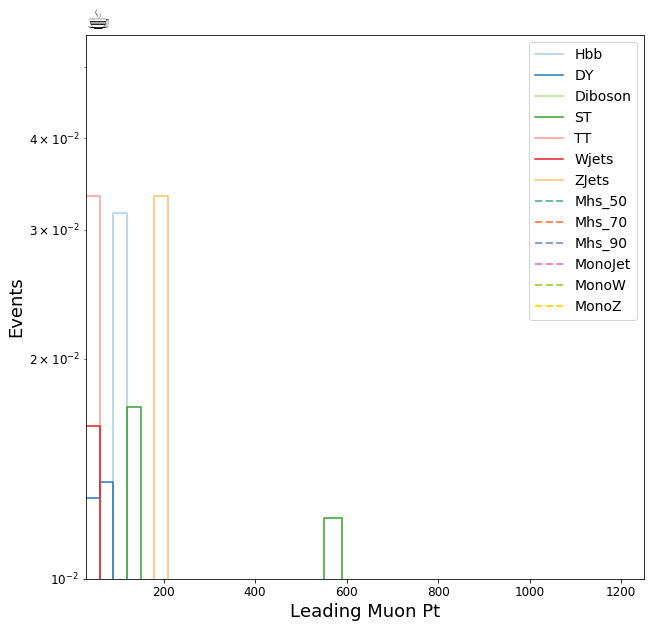

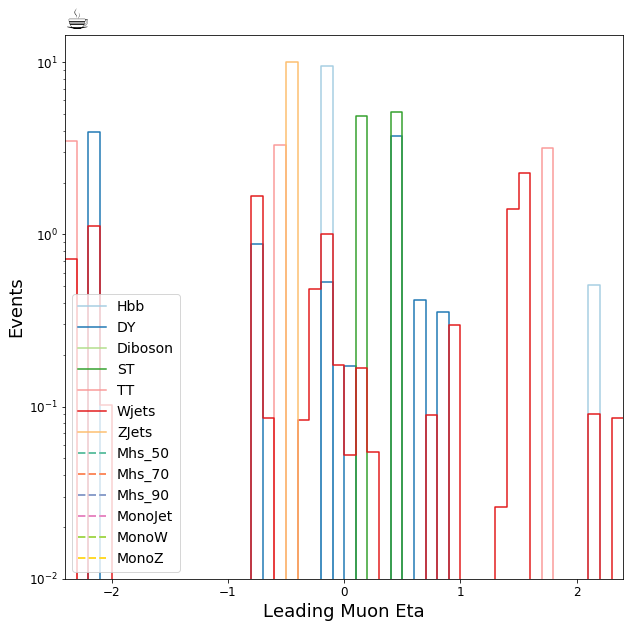

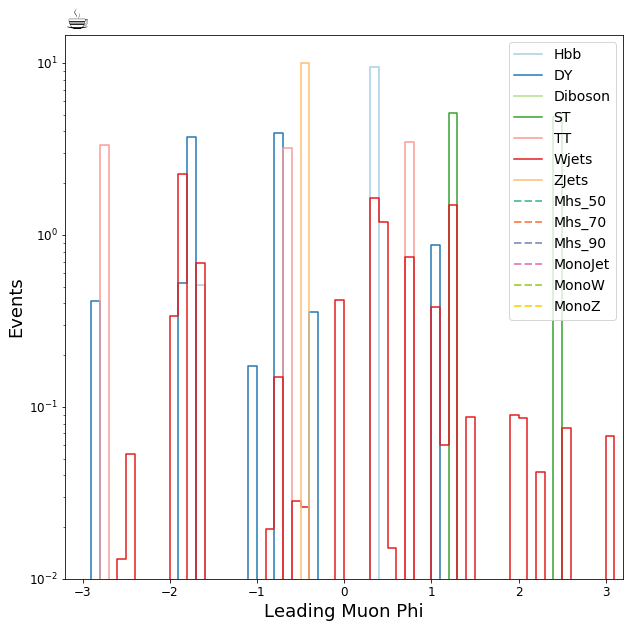

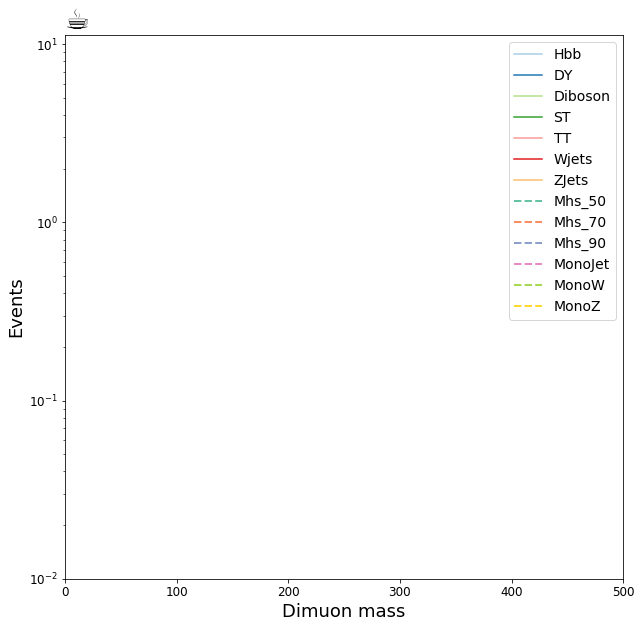

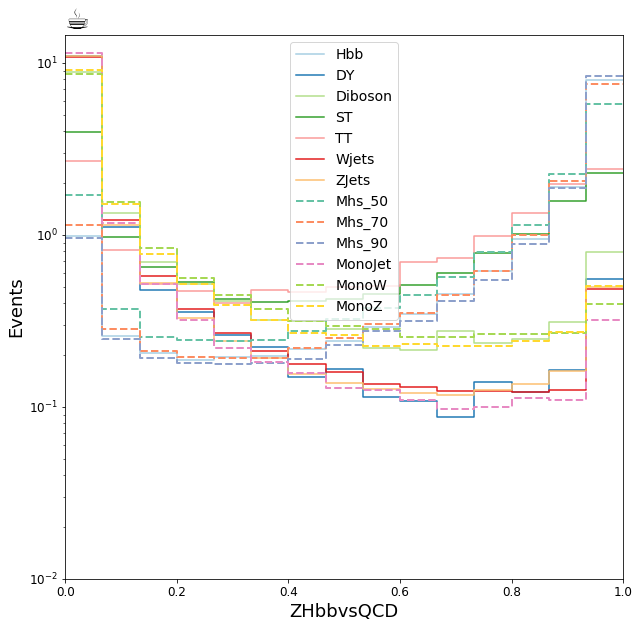

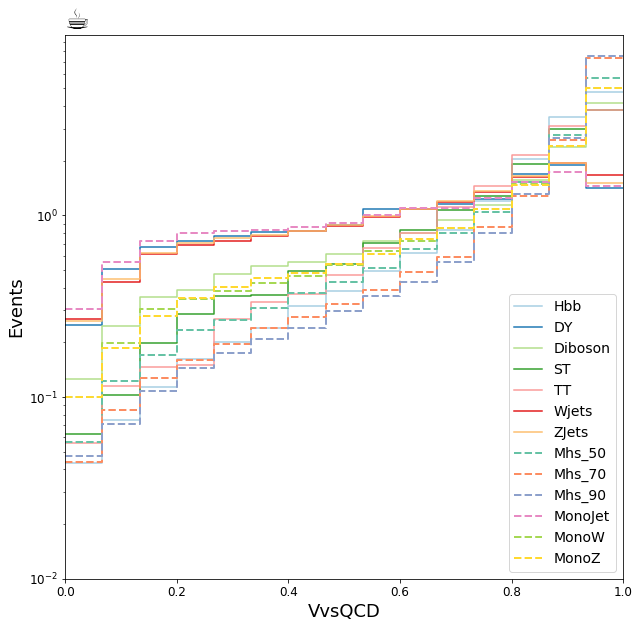

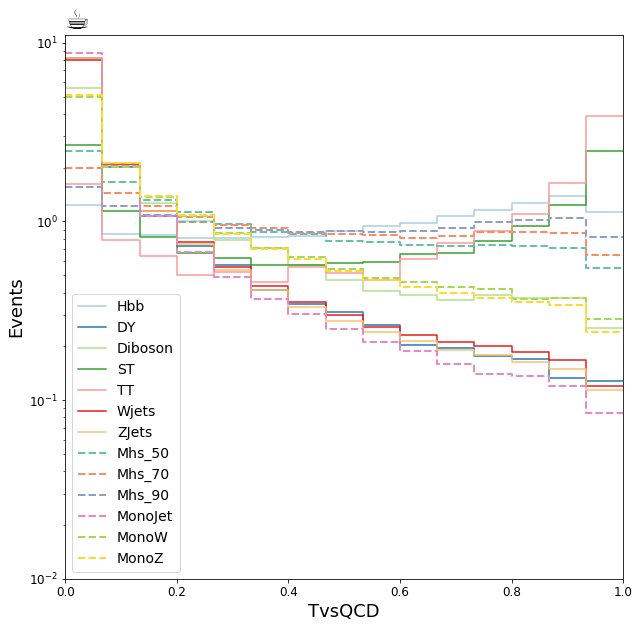

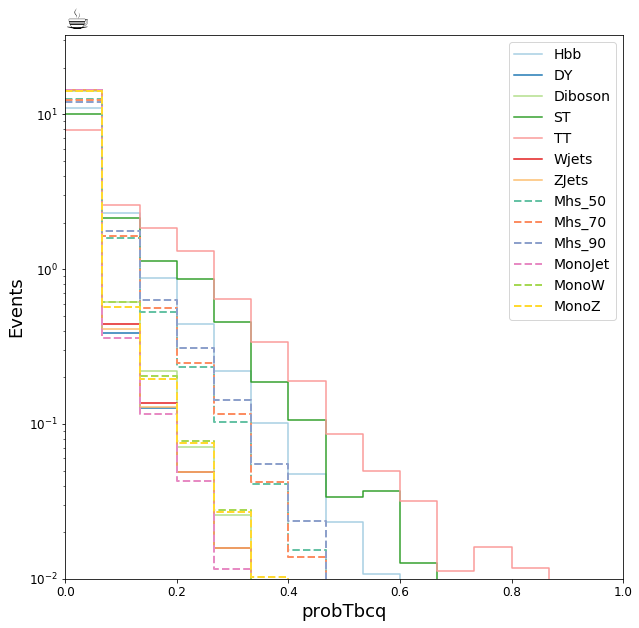

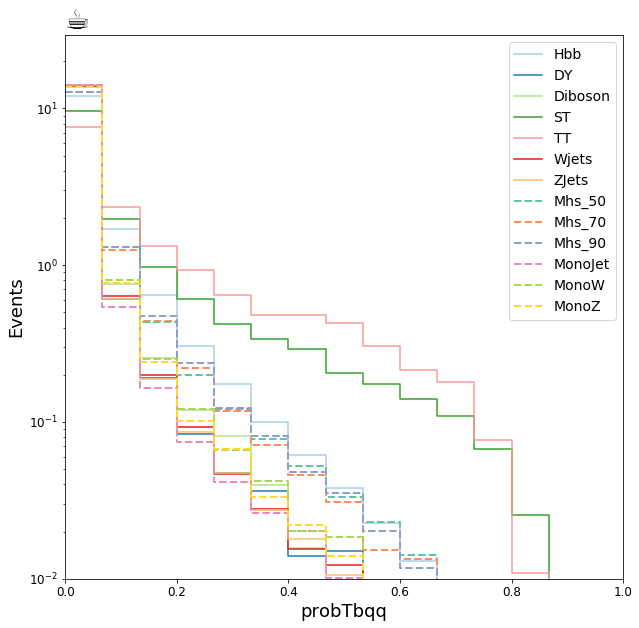

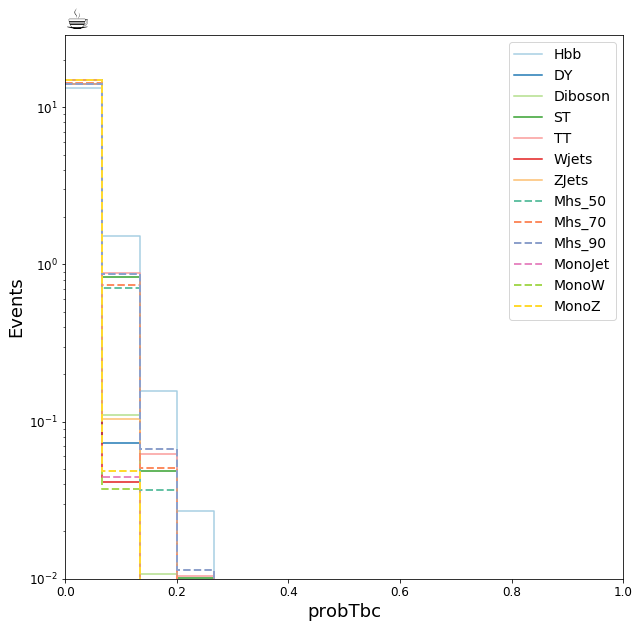

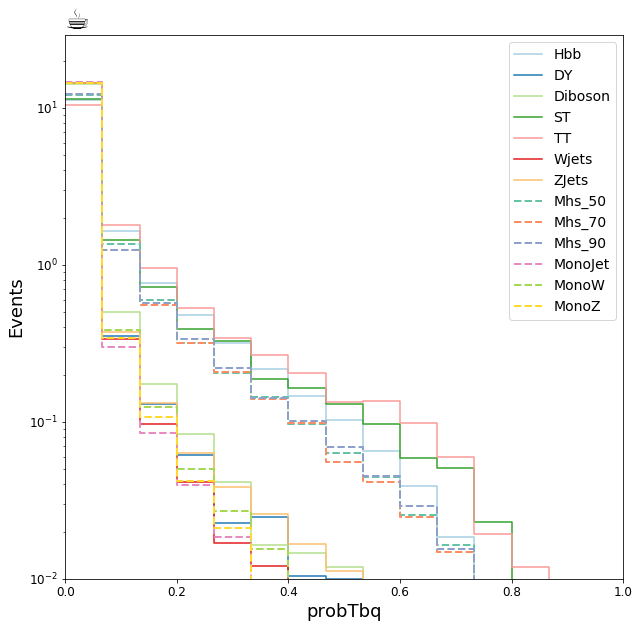

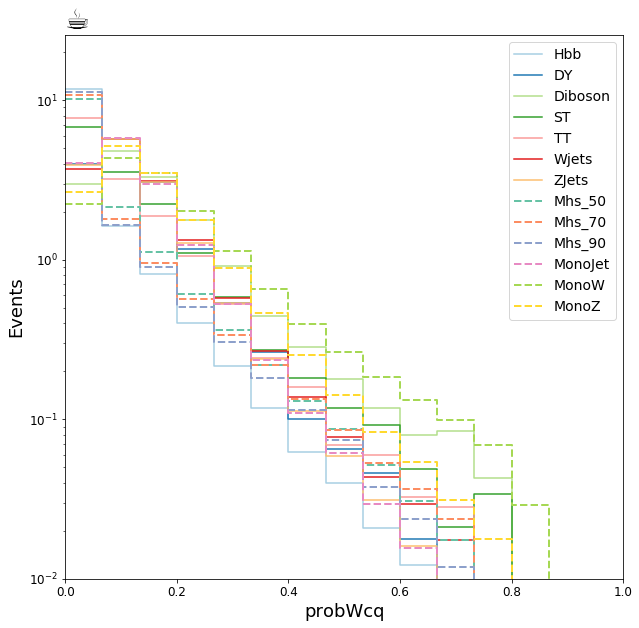

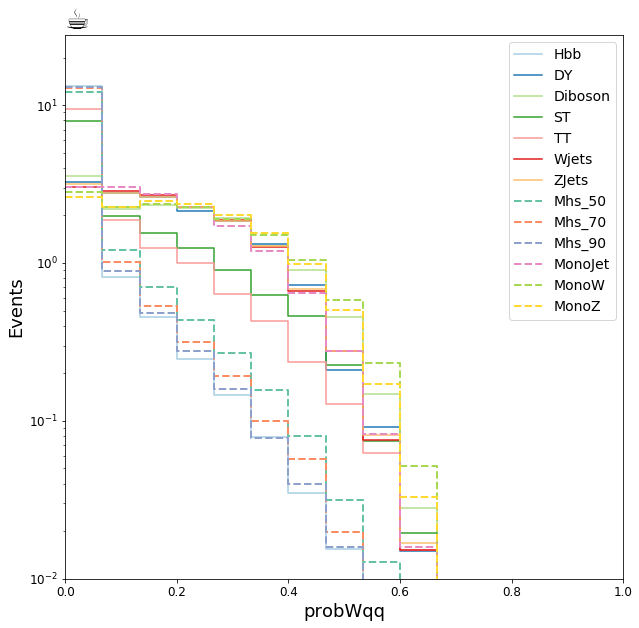

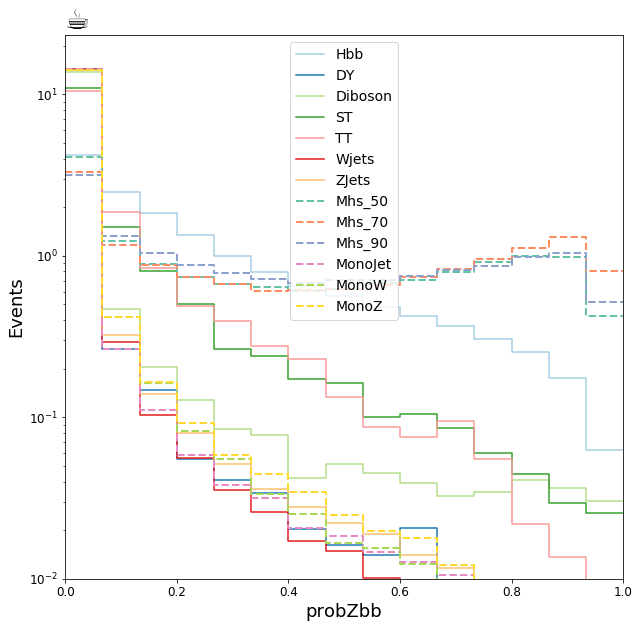

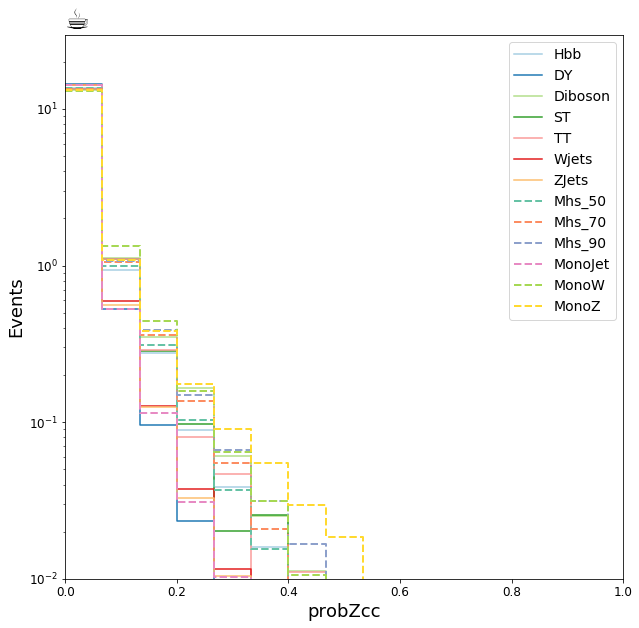

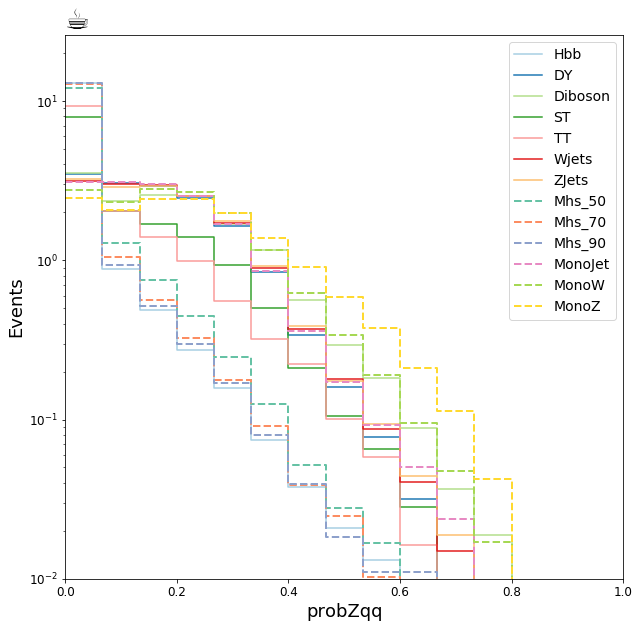

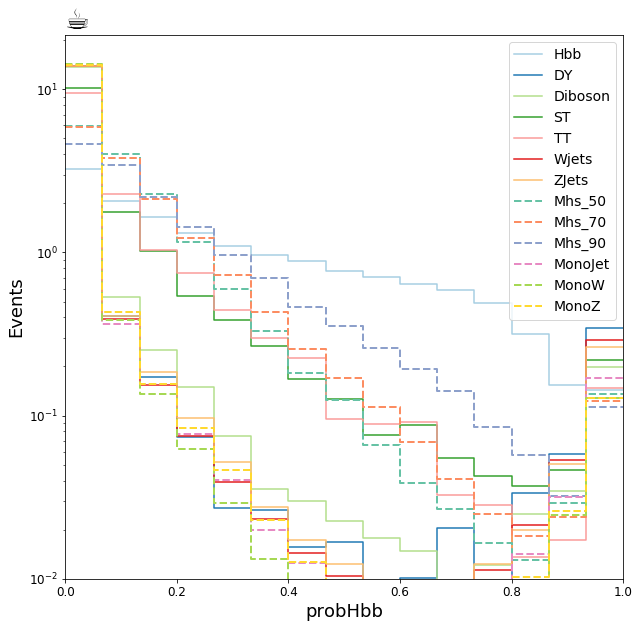

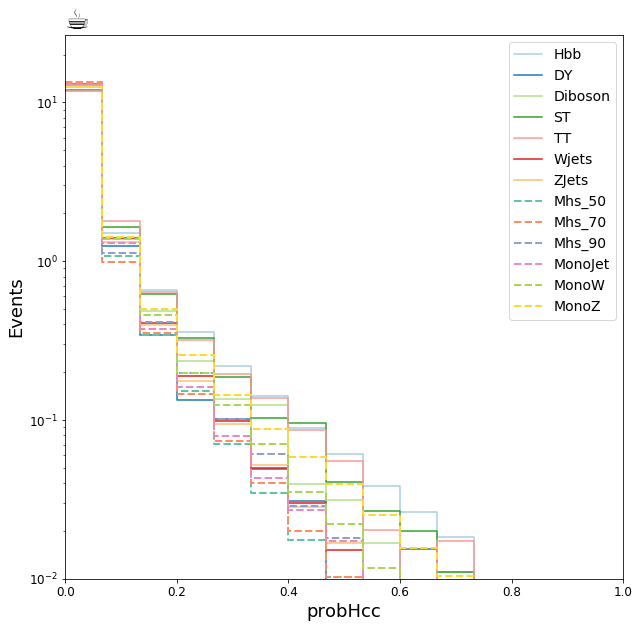

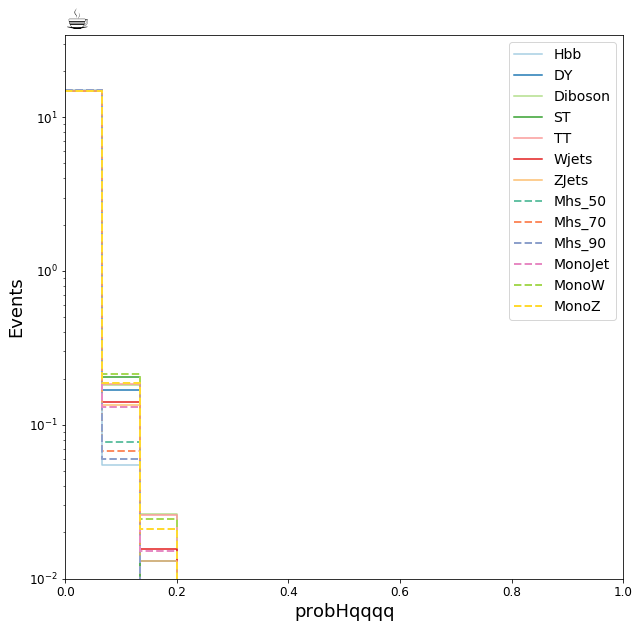

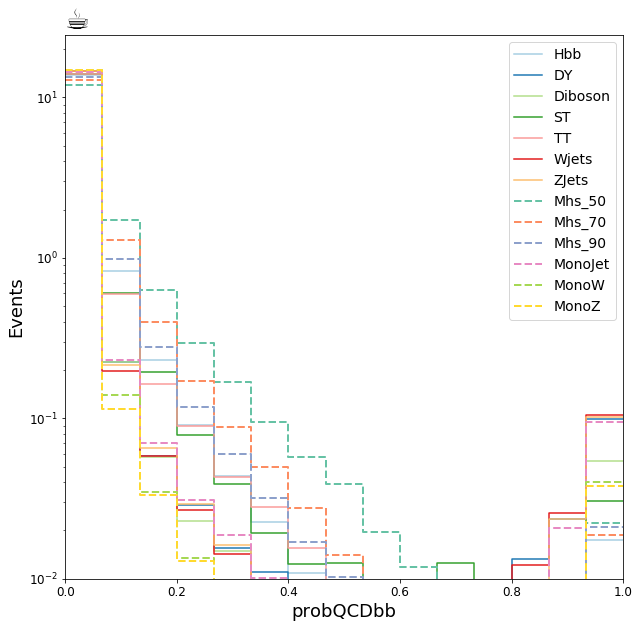

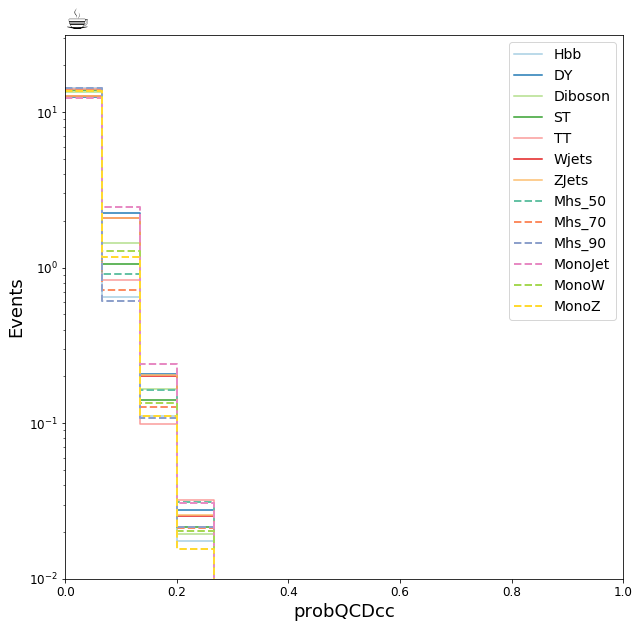

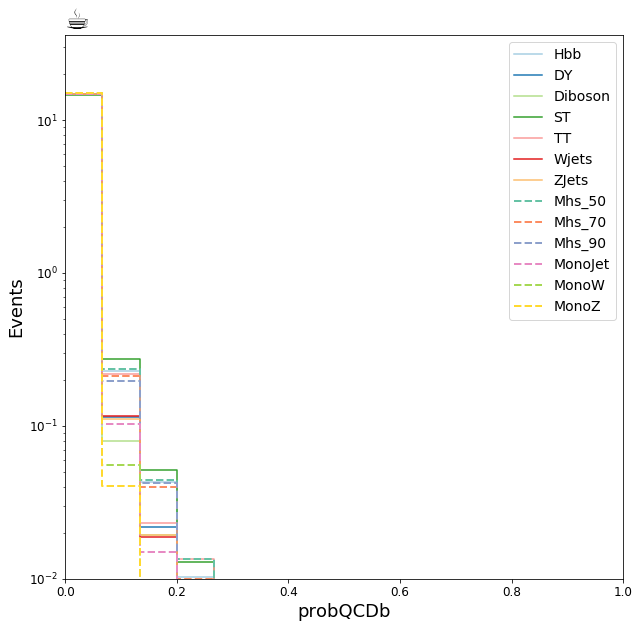

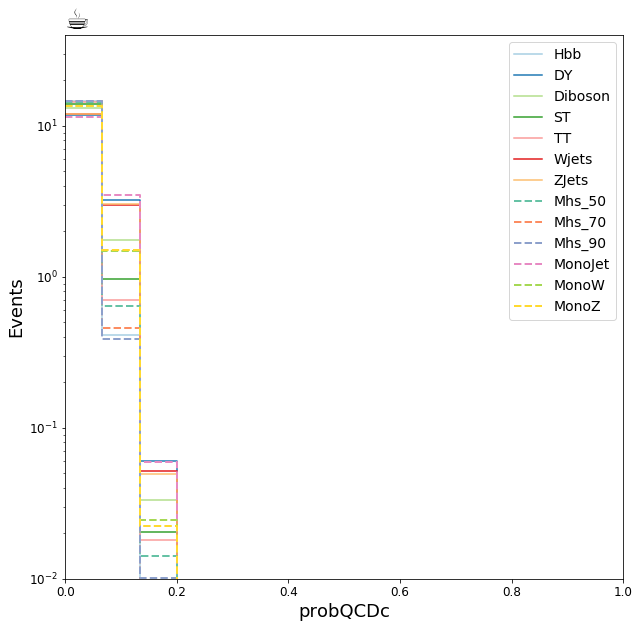

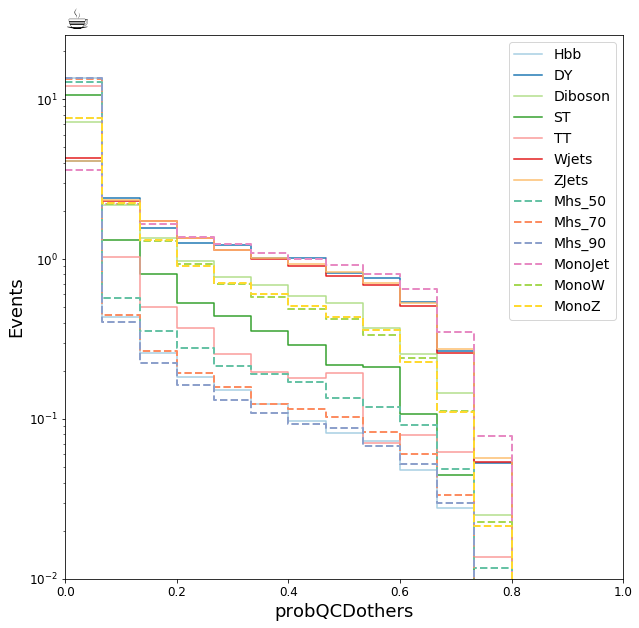

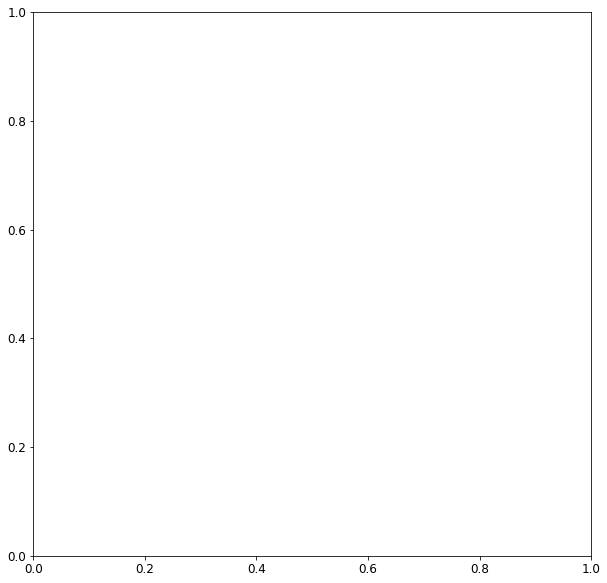

In [9]:
from cycler import cycler
colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']


if not os.path.exists('unstack'):
    os.makedirs('unstack')


for key in bkg_hists.keys():
    if key=='sumw': continue
    
    args = {'linestyle':'--','linewidth':2}
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.set_prop_cycle(cycler(color=colors))
    plot.plot1d(bkg_hists[key].integrate('jet_selection','baggy').integrate('region','iszeroL'), ax=ax, overlay="process", clear=False, stack=False, line_opts={},density=1)
    plot.plot1d(signal_hists[key].integrate('jet_selection','baggy').integrate('region','iszeroL'), ax=ax, overlay="process", clear=False, stack=False, line_opts=args,density=1)
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('log')
    ax.set_ylim(.01, None)
    leg = ax.legend()
    coffee = plt.text(0., 1., u"☕", fontsize=28, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    #lumi = plt.text(1., 1., r"1 fb$^{-1}$ (13 TeV)", fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
    plot_path = os.path.abspath('unstack')
    plot_name = 'unstack'+key+'.png'
    fig.savefig(os.path.join(plot_path, plot_name))